<a href="https://colab.research.google.com/github/KonstantinaT/Predictor/blob/main/Tier_CGI_humsavar_other.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use of Prott5 representations as features for the training of FC NN. Training set Tier1_2_3_humsavar and Tier1_2_3_Other with sequences smaller than 2000AA. Test on DRGN and CPV 

## Libraries, Classes and Functions

In [ ]:
import csv
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import gc
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import matthews_corrcoef
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from numpy import asarray,savez_compressed
pd.set_option("display.max_rows", None, "display.max_columns", None)
!pip install -q SentencePiece transformers
from transformers import AdamW, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup, T5EncoderModel, T5Tokenizer
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.nn.utils.rnn import pad_sequence
import requests
import warnings
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
#from torch.utils import data
import re
import os
!pip install Biopython

     |████████████████████████████████| 1.2 MB 4.5 MB/s 
     |████████████████████████████████| 4.4 MB 29.1 MB/s 
     |████████████████████████████████| 596 kB 59.2 MB/s 
     |████████████████████████████████| 101 kB 8.9 MB/s 
     |████████████████████████████████| 6.6 MB 22.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 5.0 MB/s 


In [ ]:
# evaluates the performance of a model and return the predictions and ground truth
def eval(model, loader):
    model.eval()
    outputs = []
    predictions = []
    for i, batch in enumerate(loader):
        sequences = batch[0].to(device)
        output = batch[1].to(device)
        output = output.flatten()
        prediction = model(sequences)

        prediction = torch.round(prediction.squeeze()).flatten()  # rounds to the nearest integer

        predictions.append(prediction.detach().cpu().numpy())
        outputs.append(output.detach().cpu().numpy())
    
    return np.hstack(predictions), np.hstack(outputs)


# implementation of a single training epoch
def train_epoch(net, loader, loss_fn, optimizer, scheduler):
    
    # set the network in training mode
    net.train()
    
    # keep track of the loss
    loss_cum = 0
    cnt = 0
    num_correct = 0
    targets = []
    predictions = []
    
    for i, data in enumerate(loader): 
        
        # sample data
        x, y = data
        x = x.to(device)
        y = y.to(device)
        
        # set all gradients equal to zero
        net.zero_grad()
        
        # feed the batch to the network and compute the outputs
        y_pred = net(x)
        #y_pred_sq = np.squeeze(y_pred) # add when using loss_fn: BCEloss()
        
        pred = torch.round(y_pred.squeeze())  # rounds to the nearest integer
  
        # compare predictions to true label
        #correct_tensor = pred.eq(y.float().view_as(pred))
        #correct = np.squeeze(correct_tensor.cpu().numpy())
        #num_correct += np.sum(correct)
        targets.extend(y.cpu().detach().numpy().tolist())
        predictions.extend(torch.sigmoid(y_pred).cpu().detach().numpy().tolist())

        #predictions_round = [round(p) for p in predictions]
        #correct_tensor = predictions_round.eq(targets.float().view_as(predictions_round))

        #loss = loss_fn(y_pred_sq, y.float())  #add when using loss_fn: BCEloss()
        loss = loss_fn(y_pred, y.float())

        # Specify L1 and L2 weights
        l1_weight = 0
        l2_weight = 0
        
        # Compute L1 and L2 loss component
        parameters = []
        for parameter in net.parameters():
            parameters.append(parameter.view(-1))
        l1 = l1_weight * net.compute_l1_loss(torch.cat(parameters))
        l2 = l2_weight * net.compute_l2_loss(torch.cat(parameters))
        
        # Add L1 and L2 loss components
        loss += l1
        loss += l2

        loss_cum += loss.data.cpu().numpy()
        cnt += 1

        # backpropagate the gradients w.r.t. computed loss
        loss.backward()

        # apply one step in the optimization
        optimizer.step()
        scheduler.step()
        
        #break #for training one batch
          
    # compute the average loss
    #mytrain_acc = num_correct 
    loss_avg = loss_cum / cnt

    #predictions = np.array(predictions) >= 0.5
    predictions = [1 if p[0] > 0.5 else 0 for p in predictions]
    mytrain_acc  = metrics.accuracy_score(targets, predictions)   *100
    #mytrain_acc = (num_correct/ (len(y)*cnt)) *100

    return loss_avg, mytrain_acc

def loss_fn(outputs, targets):
  return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))

In [ ]:
# implementation of a single testing epoch
def test_epoch(net, loader, loss_fn):
    
    # set the network in evaluation mode
    net.eval()
    
    # keep track of the loss
    loss_cum = 0
    cnt = 0
    num_correct_val = 0
    targets = []
    predictions = []
    with torch.no_grad():
      for i, data in enumerate(loader): 

          x, y = data
          x = x.to(device)
          y = y.to(device)
          
          # feed the batch to the network and compute the outputs
          y_pred = net(x)
         
          #y_pred_sq = np.squeeze(y_pred) #add when using loss_fn: BCEloss()
          pred = torch.round(y_pred.squeeze())  # rounds to the nearest integer
          
          # compare predictions to true label
          #correct_tensor = pred.eq(y.float().view_as(pred))
          #correct = np.squeeze(correct_tensor.cpu().numpy())
          
          targets.extend(y.cpu().detach().numpy().tolist())
          predictions.extend(torch.sigmoid(y_pred).cpu().detach().numpy().tolist())

          #num_correct_val += np.sum(correct)
          # compare the outputs to the labels with the loss function
          #loss = loss_fn(y_pred_sq, y.float())  #ad|d when using loss_fn: BCEloss()
          loss = loss_fn(y_pred, y.float())

          # Specify L1 and L2 weights
          l1_weight = 0
          l2_weight = 0
          
          # Compute L1 and L2 loss component
          parameters = []
          for parameter in net.parameters():
              parameters.append(parameter.view(-1))
          l1 = l1_weight * net.compute_l1_loss(torch.cat(parameters))
          l2 = l2_weight * net.compute_l2_loss(torch.cat(parameters))
          
          # Add L1 and L2 loss components
          loss += l1
          loss += l2
            
          loss_cum += loss.data.cpu().numpy()
          cnt += 1
    print(predictions)      
    # compute the average loss
    #len_trainx = len(loader) * len(y_pred)
    #mytest_acc = num_correct_val 
    loss_avg = loss_cum / cnt
    predictions = np.array(predictions) >= 0.5
    mytest_acc  = (metrics.accuracy_score(targets, predictions)) *100
    
    return loss_avg, mytest_acc

In [ ]:
def train_net(net, train_loader, val_loader, loss_fn, optimizer, epochs , scheduler):
    
    # transfer the network to the GPU
    net = net.to(device)
    
    train_loss = np.zeros((epochs))
    test_loss = np.zeros((epochs))
    train_acc = np.zeros((epochs))
    train_acc_alt = np.zeros((epochs))
    
    test_acc = np.zeros((epochs))
    test_acc_alt = np.zeros((epochs))
    
    print("Begin training.")

    for epoch in tqdm(range(epochs)):
        
        # training
        train_loss[epoch], train_acc[epoch] = train_epoch(net, train_loader, loss_fn, optimizer, scheduler)
        #predictions, outputs = eval(net, train_loader)
        #train_acc_alt[epoch] = metrics.accuracy_score(outputs, predictions)

        # validation
        test_loss[epoch], test_acc[epoch] = test_epoch(net, val_loader, loss_fn)
        #predictions, outputs = eval(net, val_loader)
        #test_acc_alt[epoch] = metrics.accuracy_score(outputs, predictions)
        
        print('Epoch %5d - Train loss: %.6f - Train accuracy: %.6f - Test loss: %.6f - Test accuracy: %.6f' 
             % (epoch, train_loss[epoch], train_acc[epoch], test_loss[epoch], test_acc[epoch]))

    return (train_loss, test_loss), (train_acc , test_acc)
    #return train_loss, train_acc # for training one batch

In [ ]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [ ]:
class toyRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, output_size, hidden_dim, n_layers):
        """
        Initialize the model by setting up the layers.
        """
        super(toyRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        in_channels = 1

        self.gru = nn.GRU(in_channels, hidden_dim, n_layers, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.4)
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        nn.init.xavier_normal_(self.fc.weight)
        self.sig = nn.Sigmoid()

         
    def forward(self, x, hidden, test_var=False):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)  
        # embeddings and lstm_out
        #print('hidden', hidden[0].size())

        lstm_out, hidden = self.gru(x, hidden)
       
        # stack up lstm outputs
        lstm = lstm_out.contiguous().view(-1, self.hidden_dim)
        # dropout and fully-connected layer
        out = self.dropout(lstm)
        
        # dropout and fully-connected layer
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        if test_var == True:
          return lstm_out
        # return last sigmoid output and hidden state
        else:
          return sig_out , hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).cuda()

        return hidden

In [ ]:
class Classifier(nn.Module):
    def __init__(self, hidden, dropout=0):
        super(Classifier, self).__init__()
        self.hidden = hidden
        self.num_feature = 2000
        self.dropout = dropout
        self.batchnorm1 = nn.BatchNorm1d(self.hidden)

        self.layer_1 = nn.Linear(self.num_feature,  self.hidden)
        self.layer_2 = nn.Linear( self.hidden, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        #x = self.batchnorm2(x)
        #x = self.sigmoid(x)
        
        return x

    def compute_l1_loss(self, w):
        return torch.abs(w).sum()

    def compute_l2_loss(self, w):
        return torch.square(w).sum()

In [ ]:
def dataset_with_indices(cls):
    """
    Modifies the given Dataset class to return a tuple data, target, index
    instead of just data, target.
    """

    def __getitem__(self, index):
        data, target = cls.__getitem__(self, index)
        return data, target, index

    return type(cls.__name__, (cls,), {
        '__getitem__': __getitem__,
    })


DWithInd = dataset_with_indices(torch.utils.data.TensorDataset)

In [ ]:
def Average(lst):
  return sum(lst) /len(lst)

In [ ]:
def get_class_distribution_binary(obj):
    count_dict = {
        'Neutral': 0,
        'Deleterious': 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['Neutral'] += 1
        elif i == 1: 
            count_dict['Deleterious'] += 1
        
        else:
            print("Check classes.")
            
    return count_dict

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [ ]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    print(f'{len(unique_list)} unique transcripts')
    return unique_list

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01) 
        #nn.init.xavier_normal_(m.weight)

    if type(m) == nn.LSTM:
      for param in m._flat_weights_names:
          if "weight" in param:
              nn.init.xavier_uniform_(m._parameters[param])

In [ ]:
class LSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, output_size, hidden_dim, n_layers):
        """
        Initialize the model by setting up the layers.
        """
        super(LSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        in_channels = 1

        #self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
        #                    batch_first=True, bidirectional=True)
        self.lstm = nn.LSTM(in_channels, hidden_dim,
                            n_layers, batch_first=True, bidirectional=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.4)
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        nn.init.xavier_normal_(self.fc.weight)
        self.sig = nn.Sigmoid()

         
    def forward(self, x, hidden, test_var=False):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)  
        # embeddings and lstm_out
        #print('hidden', hidden[0].size())

        lstm_out, hidden = self.lstm(x, hidden)
       
        # stack up lstm outputs
        lstm = lstm_out.contiguous().view(-1, self.hidden_dim)
        # dropout and fully-connected layer
        out = self.dropout(lstm)
        
        # dropout and fully-connected layer
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        if test_var == True:
          return lstm_out
        # return last sigmoid output and hidden state
        else:
          return sig_out , hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if (train_on_gpu):
            #hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().cuda())
            hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().cuda())
            #nn.init.xavier_normal_(hidden)
        else:
            hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_())

        return hidden

## Load Prot t5 Model 

In [ ]:
# Advanced
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model = model.eval()
gc.collect()

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.5G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.4.layer.0.SelfAttention.k.weight', 'decoder.block.9.layer.0.SelfAttention.q.weight', 'decoder.block.18.layer.1.EncDecAttention.k.weight', 'decoder.block.21.layer.0.SelfAttention.k.weight', 'decoder.block.19.layer.1.layer_norm.weight', 'decoder.block.20.layer.1.EncDecAttention.o.weight', 'decoder.block.20.layer.2.layer_norm.weight', 'decoder.block.17.layer.1.EncDecAttention.k.weight', 'decoder.block.18.layer.0.SelfAttention.o.weight', 'decoder.block.7.layer.1.EncDecAttention.q.weight', 'decoder.block.12.layer.2.layer_norm.weight', 'decoder.block.18.layer.0.SelfAttention.k.weight', 'decoder.block.8.layer.0.SelfAttention.q.weight', 'decoder.block.22.layer.2.DenseReluDense.wo.weight', 'decoder.block.4.layer.1.layer_norm.weight', 'decoder.block.11.layer.1.layer_norm.weight', 'decoder.block.18.layer.2.DenseReluDense.wo.weight', 'decoder.block.14.layer.1.EncDecAt

1055

##Load DRGN / CPV mutations

Find creation of sets here: [link text](https://colab.research.google.com/drive/1mhIHCpEekHNcFI8Ql9p79RSu1T4Y1iUl#scrollTo=CWNrIjS231bc)

In [ ]:
DRGN = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/DRGN_mutations.csv')

In [ ]:
seq_all =[]
for i, mut in DRGN.iterrows():
  seq_all.append(mut['mut_sequence'])

# Add spaces between Amino Acids
seq_spaced = []
for seq_single in seq_all:
  temp = " ".join(seq_single)
  seq_spaced.append(temp)
len_sequences = len(seq_spaced)

In [ ]:
indices_to_excl = []
seq_pooled = []
count=0
BATCH_FILE_SIZE = 2000
for i in seq_spaced:
    count+=1
    #print('Length of sequence', len(i) )
    ids = tokenizer.batch_encode_plus([i], add_special_tokens=True, padding='longest')
    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)
    try:
        with torch.no_grad():
            embedding = model(input_ids=input_ids,attention_mask=attention_mask)
        embedding = embedding.last_hidden_state.cpu().numpy()
        
        for seq_num in range(len(embedding)):
            seq_len = (attention_mask[seq_num] == 1).sum()
            seq_emd = embedding[seq_num][:seq_len-1]
            # seq_emd = embedding[seq_num]
            # print('After cropping: ', seq_emd.shape)
            seq_temp = torch.tensor(seq_emd)
            #seq_emd_pooled = m(seq_temp)
            #print('After maxpooling:', seq_emd_pooled.shape)
        
        seq_pooled.append(seq_temp)
        
        if not count % BATCH_FILE_SIZE:
            print('Count is:', count)
            print('Seq_pooled size is:', len(seq_pooled))
            with open(f'/content/drive/MyDrive/my_colab/3rdYear/ProTrans/prott5_DRGN_{int(count/BATCH_FILE_SIZE)}.pickle', 'wb') as handle:
                print('count/batch:' , int(count/BATCH_FILE_SIZE))
                pickle.dump(seq_pooled, handle)
            seq_pooled = []
        
    except:
        indices_to_excl.append(count - 1)


if count % BATCH_FILE_SIZE: # for last sequences 
    with open(f'/content/drive/MyDrive/my_colab/3rdYear/ProTrans/prott5_DRGN_{math.ceil(count/BATCH_FILE_SIZE)}.pickle', 'wb') as handle:
        pickle.dump(seq_pooled, handle)  
print(len(seq_pooled))


with open('/content/drive/MyDrive/my_colab/3rdYear/ProTrans/prott5_DRGN_indices_to_excl.pickle', 'wb') as handle:
    pickle.dump(indices_to_excl, handle)

Count is: 2000
Seq_pooled size is: 1990
count/batch: 1
1631


In [ ]:
CPV = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/CPV_mutations.csv')

In [ ]:
seq_all =[]
for i, mut in CPV.iterrows():
  seq_all.append(mut['mut_sequence'])

# Add spaces between Amino Acids
seq_spaced = []
for seq_single in seq_all:
  temp = " ".join(seq_single)
  seq_spaced.append(temp)
len_sequences = len(seq_spaced)
#m = nn.MaxPool1d(50) #, ceil_mode=True) # Max Pooling for reduction of features from 1024 to 20 per AA, and to 25

In [ ]:
indices_to_excl = []
seq_pooled = []
count=0
BATCH_FILE_SIZE = 2000
for i in seq_spaced:
    count+=1
    #print('Length of sequence', len(i) )
    ids = tokenizer.batch_encode_plus([i], add_special_tokens=True, padding='longest')
    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)
    try:
        with torch.no_grad():
            embedding = model(input_ids=input_ids,attention_mask=attention_mask)
        embedding = embedding.last_hidden_state.cpu().numpy()
        
        for seq_num in range(len(embedding)):
            seq_len = (attention_mask[seq_num] == 1).sum()
            seq_emd = embedding[seq_num][:seq_len-1]
            seq_temp = torch.tensor(seq_emd)
            #seq_emd_pooled = m(seq_temp)
        seq_pooled.append(seq_temp)

        if not count % BATCH_FILE_SIZE:
            print('Count is:', count)
            print('Seq_pooled size is:', len(seq_pooled))
            with open(f'/content/drive/MyDrive/my_colab/3rdYear/ProTrans/prott5_CPV_{int(count/BATCH_FILE_SIZE)}.pickle', 'wb') as handle:
                print('count/batch:' , int(count/BATCH_FILE_SIZE))
                pickle.dump(seq_pooled, handle)
            seq_pooled = []
        
    except:
        indices_to_excl.append(count - 1)


if count % BATCH_FILE_SIZE: # for last sequences 
    with open(f'/content/drive/MyDrive/my_colab/3rdYear/ProTrans/prott5_CPV_{math.ceil(count/BATCH_FILE_SIZE)}.pickle', 'wb') as handle:
        pickle.dump(seq_pooled, handle)  
print(len(seq_pooled))


with open('/content/drive/MyDrive/my_colab/3rdYear/ProTrans/prott5_CPV_indices_to_excl.pickle', 'wb') as handle:
    pickle.dump(indices_to_excl, handle)

238


# Tier1_2_3_CGI_humsavar

Load Tier1_2_3_CGI_humsavar mutations. Find creation of set here: [link text](https://colab.research.google.com/drive/1mhIHCpEekHNcFI8Ql9p79RSu1T4Y1iUl#scrollTo=CWNrIjS231bc)

In [ ]:
Tier1_2_3_CGI_humsavar =pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/Tier1_2_3_CGI_humsavar.csv')
Tier1_2_3_CGI_humsavar = Tier1_2_3_CGI_humsavar.sort_values(by='uniprot') 

## Calculate prot5 representations

In [ ]:
seq_all =[]
for i, mut in Tier1_2_3_CGI_humsavar.iterrows():
  seq_all.append(mut['mut_sequence'])

# Add spaces between Amino Acids
seq_spaced = []
for seq_single in seq_all:
  temp = " ".join(seq_single)
  seq_spaced.append(temp)
len_sequences = len(seq_spaced)

In [ ]:
indices_to_excl = []
seq_pooled = []
count=0
BATCH_FILE_SIZE = 2000
for i in seq_spaced:
    count+=1
    #print('Length of sequence', len(i) )
    ids = tokenizer.batch_encode_plus([i], add_special_tokens=True, padding='longest')
    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)
    try:
        with torch.no_grad():
            embedding = model(input_ids=input_ids,attention_mask=attention_mask)
        embedding = embedding.last_hidden_state.cpu().numpy()
        
        for seq_num in range(len(embedding)):
            seq_len = (attention_mask[seq_num] == 1).sum()
            seq_emd = embedding[seq_num][:seq_len-1]
            seq_temp = torch.tensor(seq_emd)
        seq_pooled.append(seq_temp)
        
        if not count % BATCH_FILE_SIZE:
            print('Count is:', count)
            print('Seq_pooled size is:', len(seq_pooled))
            with open(f'/content/drive/MyDrive/my_colab/3rdYear/ProTrans/prott5_Tier1_2_3_CGI_humsavar_{int(count/BATCH_FILE_SIZE)}.pickle', 'wb') as handle:
                print('count/batch:' , int(count/BATCH_FILE_SIZE))
                pickle.dump(seq_pooled, handle)
            seq_pooled = []
        
    except:
        indices_to_excl.append(count - 1)


if count % BATCH_FILE_SIZE: # for last sequences 
    with open(f'/content/drive/MyDrive/my_colab/3rdYear/ProTrans/prott5_Tier1_2_3_CGI_humsavar_{math.ceil(count/BATCH_FILE_SIZE)}.pickle', 'wb') as handle:
        pickle.dump(seq_pooled, handle)  
print(len(seq_pooled))


with open('/content/drive/MyDrive/my_colab/3rdYear/ProTrans/prott5_Tier1_2_3_CGI_humsavar_indices_to_excl.pickle', 'wb') as handle:
    pickle.dump(indices_to_excl, handle)

Count is: 2000
Seq_pooled size is: 1966
count/batch: 1
Count is: 4000
Seq_pooled size is: 1949
count/batch: 2
Count is: 6000
Seq_pooled size is: 1980
count/batch: 3
Count is: 8000
Seq_pooled size is: 1868
count/batch: 4
Count is: 10000
Seq_pooled size is: 1831
count/batch: 5
236


## Exclude DRGN and CPV mutations

In [ ]:
with open('/content/drive/MyDrive/my_colab/3rdYear/ProTrans/prott5_Tier1_2_3_CGI_humsavar_indices_to_excl.pickle', 'rb') as handle:
    indices_to_excl = pickle.load(handle)

In [ ]:
Tier1_2_3_CGI_humsavar = Tier1_2_3_CGI_humsavar.reset_index(drop=True)
Tier1_2_3_CGI_humsavar = Tier1_2_3_CGI_humsavar.drop(Tier1_2_3_CGI_humsavar.index[indices_to_excl])

In [ ]:
ind_exc = []
Tier1_2_3_CGI_humsavar = Tier1_2_3_CGI_humsavar.reset_index(drop=True)
for i, mut in Tier1_2_3_CGI_humsavar.iterrows():
  found = False
  uniprot = mut['uniprot']
  temp_df = DRGN[DRGN['uniprot id'] == uniprot]
  for k, mu2 in temp_df.iterrows():
    if mu2['position'] == mut['position'] and mu2['AA_targ'] == mut['AA_targ'] :
      ind_exc.append(i)
      found = True
      break

  if found == False:    
    temp_cpv = CPV[CPV['uniprot id'] == uniprot]
    for k, mu2 in temp_cpv.iterrows():
      if mu2['position'] == mut['position'] and mu2['AA_targ'] == mut['AA_targ'] :
        ind_exc.append(i)
        found = True
        break

In [ ]:
# Remove sequences bigger than 2000AA
ind_2000AA = []
for i, mut in Tier1_2_3_CGI_humsavar.iterrows():
  if len(mut['mut_sequence']) > 2000:
    ind_2000AA.append(i)

In [ ]:
ind_all = list(set(ind_exc + ind_2000AA))
Tier1_2_3_CGI_humsavar = Tier1_2_3_CGI_humsavar.drop(Tier1_2_3_CGI_humsavar.index[ind_all])
Tier1_2_3_CGI_humsavar = Tier1_2_3_CGI_humsavar.reset_index(drop=True)

In [ ]:
seq_all_nocrop = []
gc.collect()
#count = -1 # used to exclude DRGN and CPV sequences
for k in range(1, 7):
  with open(f'/content/drive/MyDrive/my_colab/3rdYear/ProTrans/prott5_Tier1_2_3_CGI_humsavar_{k}.pickle','rb') as file_handle:
    file_temp = pickle.load(file_handle) # load the sequences of one batch (2000)

    seq_temp = []
    for seq in file_temp:
      #count+=1
      #if count in ind_all: # for excluding the GDRN / CPV
        #print('count :', count)
      #  continue
      AA_seq_temp = []
      for AA in seq:
        AA_seq_temp.append(torch.mean(AA))
      seq_temp.append(AA_seq_temp)
    seq_all_nocrop = seq_all_nocrop + seq_temp
    del file_temp, seq_temp, AA_seq_temp
    gc.collect()

In [ ]:
print(len(seq_all_nocrop), len(seq_all_nocrop[2]))

9830 756


In [ ]:
# Pad to 2000 AA
seq_all_cropped = []
for seq_single in seq_all_nocrop:
  seq_single = torch.tensor(seq_single)

  to_pad = 2000 - len(seq_single) 
  seq_all_cropped.append(F.pad(input=seq_single, pad=(0, to_pad), mode='constant', value=0))

In [ ]:
del seq_all_nocrop
gc.collect()
seq_cropped_flat = []
for i in seq_all_cropped:
  seq_cropped_flat.append(torch.flatten(i))

del seq_all_cropped
gc.collect()
stacked_tensor_flat = torch.stack(seq_cropped_flat)
print(stacked_tensor_flat.shape)
del seq_cropped_flat
gc.collect()

torch.Size([9830, 2000])


0

## Create Training set

In [ ]:
# seperate inputs and outputs
X = stacked_tensor_flat
y = Tier1_2_3_CGI_humsavar['label']
mu_all = Tier1_2_3_CGI_humsavar['AA_orig']+ Tier1_2_3_CGI_humsavar['position'].astype(str)+Tier1_2_3_CGI_humsavar['AA_targ']

# Split, shuffle and stratify sequences, mutations, proteins and label
X_train, X_test, y_train, y_test, mu_all_train, mu_all_test , prot_all_train, prot_all_test = train_test_split(X, y, mu_all, Tier1_2_3_CGI_humsavar['uniprot'], test_size=0.1, stratify=y, random_state=69)
# Split train into train-val
#X_train, X_val, y_train, y_val, mu_all_train, mu_all_val, prot_all_train, prot_all_val = train_test_split(X_trainval, y_trainval, mu_all_trainval, prot_all_trainval, test_size=0.1, stratify=y_trainval, random_state=21)  

# Normalize
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

del stacked_tensor_flat, X
gc.collect()

0

Text(0.5, 1.0, 'Class Distribution in Val Set')

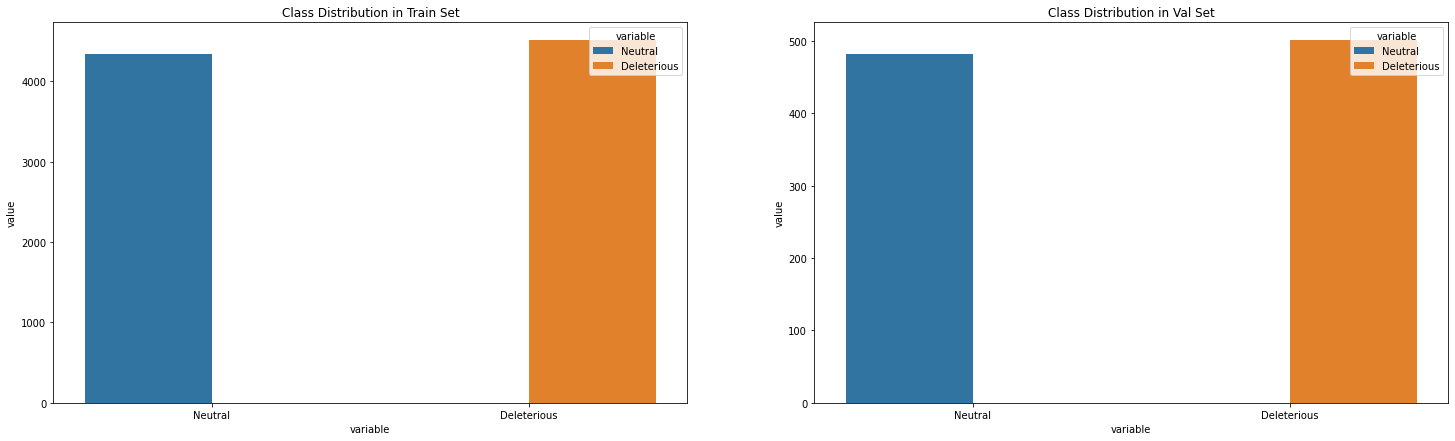

In [ ]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,7))# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_binary(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution_binary(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')

In [ ]:
BATCH_SIZE=64
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE, 
                          drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Set fixed random number seed
torch.manual_seed(42)
TRAIN_BATCH_SIZE = 64
epochs =40
lr = 1e-5

h = 128
warmup=0.2

my_net = Classifier(h, 0.2).to(device)
#my_net = Classifier(h, 0.3).to(device)

my_net.apply(init_weights)
#1st way for optimizer
optimizer = optim.AdamW(my_net.parameters(), lr=lr)#, weight_decay=0.001)
total_steps = len(X_train)/BATCH_SIZE
warmup_steps = math.floor(total_steps * warmup)
warmup_steps = math.floor(total_steps * warmup)
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

loss, acc = train_net(my_net, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler)

plt.rcParams["figure.figsize"] = (15,5)
sns.set()
# plot train/validation loss curves
plt.subplot(1, 2, 1)
plt.plot(loss[0])
plt.plot(loss[1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Learning rate: {lr}, hidden : {h}')
plt.legend(('Train', 'Validation'))
#plt.title(f'Learning rate: {lr}, hidden : {h}, hidden2: {h2}')

plt.subplot(1, 2, 2)
plt.plot(acc[0])
plt.plot(acc[1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(('Train', 'Validation'))
plt.show()

Begin training.


  0%|          | 0/40 [00:00<?, ?it/s]

[[0.5029656887054443], [0.4982428550720215], [0.5131794810295105], [0.5498263239860535], [0.51606285572052], [0.5253821611404419], [0.5353044867515564], [0.5004652142524719], [0.4875431954860687], [0.5166440606117249], [0.493082195520401], [0.5028319358825684], [0.49247226119041443], [0.5174511075019836], [0.505357563495636], [0.5067814588546753], [0.5189477205276489], [0.5078957676887512], [0.487374484539032], [0.5651715397834778], [0.5164029002189636], [0.49797725677490234], [0.4976867735385895], [0.5019675493240356], [0.49409082531929016], [0.5383560657501221], [0.5185635685920715], [0.5085482001304626], [0.5319022536277771], [0.5020603537559509], [0.509082555770874], [0.4340960681438446], [0.4962444305419922], [0.532508134841919], [0.5258751511573792], [0.5184453725814819], [0.5230602622032166], [0.5386571288108826], [0.5001348257064819], [0.5125254988670349], [0.5229385495185852], [0.5465768575668335], [0.4972681999206543], [0.5019422173500061], [0.5091131329536438], [0.5121270418

KeyboardInterrupt: ignored

Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch     0 - Train loss: 0.640257 - Train accuracy: 69.712753 - Test loss: 0.599633 - Test accuracy: 75.426136
Epoch     1 - Train loss: 0.565617 - Train accuracy: 76.815025 - Test loss: 0.540863 - Test accuracy: 80.255682
Epoch     2 - Train loss: 0.511376 - Train accuracy: 79.655934 - Test loss: 0.495127 - Test accuracy: 80.681818
Epoch     3 - Train loss: 0.469871 - Train accuracy: 81.250000 - Test loss: 0.461795 - Test accuracy: 82.102273
Epoch     4 - Train loss: 0.438550 - Train accuracy: 82.212753 - Test loss: 0.439015 - Test accuracy: 82.812500
Epoch     5 - Train loss: 0.414658 - Train accuracy: 83.143939 - Test loss: 0.423991 - Test accuracy: 82.386364
Epoch     6 - Train loss: 0.396097 - Train accuracy: 83.854167 - Test loss: 0.414067 - Test accuracy: 82.244318
Epoch     7 - Train loss: 0.381273 - Train accuracy: 84.438131 - Test loss: 0.406807 - Test accuracy: 82.102273
Epoch     8 - Train loss: 0.369150 - Train accuracy: 84.958965 - Test loss: 0.402507 - Test accuracy: 82

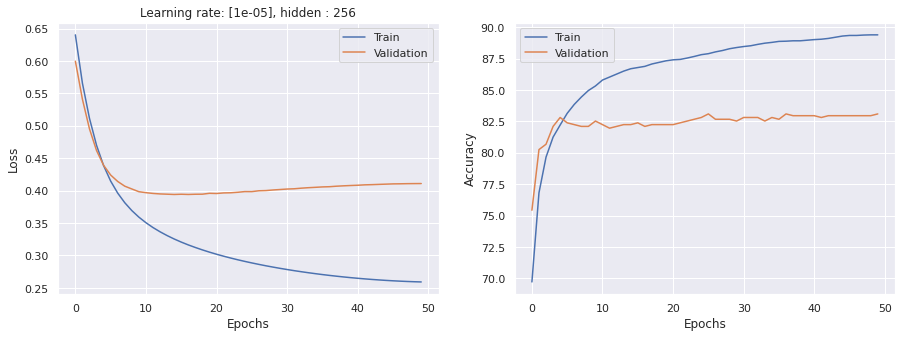

In [ ]:
# Set fixed random number seed
torch.manual_seed(42)
TRAIN_BATCH_SIZE = 64
epochs =50
lr = [1e-5]
#lr =1e-5
#h = 128
h = 256
hidden2 = 256

#my_net = Classifier2L(h, hidden2, 0.2).to(device)
my_net = Classifier(h, 0.3).to(device)
my_net.apply(init_weights)
param_optimizer = list(my_net.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

num_train_steps = int(len(X_train) / TRAIN_BATCH_SIZE * epochs)
optimizer = torch.optim.AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
#loss_fn = nn.BCELoss()
#optimizer = optim.Adam(my_net.parameters(), lr=lr)
loss, acc = train_net(my_net, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler)

plt.rcParams["figure.figsize"] = (15,5)
sns.set()
# plot train/validation loss curves
plt.subplot(1, 2, 1)
plt.plot(loss[0])
plt.plot(loss[1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Learning rate: {lr}, hidden : {h}')
plt.legend(('Train', 'Validation'))
#plt.title(f'Learning rate: {lr}, hidden : {h}, hidden2: {h2}')

plt.subplot(1, 2, 2)
plt.plot(acc[0])
plt.plot(acc[1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(('Train', 'Validation'))
plt.show()

## Test set

### CPV

In [ ]:
with open(f'/content/drive/MyDrive/my_colab/3rdYear/ProTrans/prott5_CPV_1.pickle','rb') as file_handle:
  seq_pooled_cpv= pickle.load(file_handle)

  seq_temp = []
  seq_all_nocrop_cpv = []
  for seq in seq_pooled_cpv:
    AA_seq_temp = []
    for AA in seq:
      AA_seq_temp.append(torch.mean(AA))
    seq_temp.append(AA_seq_temp)
  seq_all_nocrop_cpv = seq_all_nocrop_cpv + seq_temp


count_pos, count_neg = 0, 0
for i in CPV['label'].values:
  if i == 0:
    count_neg +=1
  elif i == 1:
    count_pos += 1
  else:
    print('else')

print(count_pos, count_neg)

154 84


In [ ]:
# Crop to 1500 AA, pad shorter ones to 2000 AA
seq_all_cropped_cpv = []
for seq_single in seq_all_nocrop_cpv:
  seq_single = torch.tensor(seq_single)
  if len(seq_single) > 2000:
    seq_all_cropped_cpv.append(seq_single[:2000])
  else:
    to_pad = 2000 - len(seq_single) 
    seq_all_cropped_cpv.append(F.pad(input=seq_single, pad=(0, to_pad), mode='constant', value=0))

In [ ]:
gc.collect()
seq_cropped_flat = []
for i in seq_all_cropped_cpv:
  seq_cropped_flat.append(torch.flatten(i))

del seq_all_cropped_cpv
gc.collect()
stacked_tensor_flat_cpv = torch.stack(seq_cropped_flat)
print(stacked_tensor_flat_cpv.shape)

torch.Size([236, 2000])


In [ ]:
X_cpv, y_cpv = np.array(stacked_tensor_flat_cpv), np.array( CPV['label'].values)
cpv_dataset = ClassifierDataset(torch.from_numpy(X_cpv).float(), torch.from_numpy(y_cpv).long())
cpv_loader = DataLoader(dataset=cpv_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_pred_list = []
predictions_cpv= []
with torch.no_grad():
    for X_batch, _ in cpv_loader:
        X_batch = X_batch.to(device)
        y_test_pred = my_net(X_batch)
        #print(y_test_pred)
        predictions_cpv.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())
        #print(predictions_cpv)

flat_list = []
for sublist in predictions_cpv:
    for item in sublist:
        flat_list.append(item)
predictions_cpv = [1 if i>=0.5 else 0 for i in flat_list]
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_cpv, predictions_cpv))
tn, fp, fn, tp = confusion_matrix(y_cpv, predictions_cpv).ravel()
print(classification_report(y_cpv, predictions_cpv))
print(tp, tn, fp, fn)
TPR =tp / (tp + fn)
print('Sensitivity: %.2f'  % (TPR*100))

TNR = tn / (tn + fp)
print('Specificity: %.2f'  % (TNR*100))

ValueError: ignored

### DRGN

In [ ]:
DRGN = pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/DRGN_mutations.csv')

In [ ]:
seq_all_nocrop_drgn  = []
for k in range(1, 3):
  with open(f'/content/drive/MyDrive/my_colab/3rdYear/ProTrans/prott5_DRGN_{k}.pickle','rb') as file_handle:
    file_temp = pickle.load(file_handle) # load the sequences of one batch (2000)

    seq_temp = []

    for seq in file_temp :
      AA_seq_temp = []
      for AA in seq:
        AA_seq_temp.append(torch.mean(AA))
      seq_temp.append(AA_seq_temp)
    seq_all_nocrop_drgn = seq_all_nocrop_drgn + seq_temp

    del file_temp, seq_temp, AA_seq_temp
    gc.collect()

count_pos, count_neg = 0, 0
for i in DRGN['label'].values:
  if i == 0:
    count_neg +=1
  elif i == 1:
    count_pos += 1
  else:
    print('else')

In [ ]:
# pad to 2000 AA
seq_all_cropped_drgn = []
for seq_single in seq_all_nocrop_drgn:
  seq_single = torch.tensor(seq_single)
  if len(seq_single) > 2000:
    seq_all_cropped_drgn.append(seq_single[:2000])
  else:
    to_pad = 2000 - len(seq_single) 
    seq_all_cropped_drgn.append(F.pad(input=seq_single, pad=(0, to_pad), mode='constant', value=0))

In [ ]:
del train_dataset, val_dataset
gc.collect()

173125

In [ ]:
gc.collect()
seq_cropped_flat = []
for i in seq_all_cropped_drgn:
  seq_cropped_flat.append(torch.flatten(i))

gc.collect()
stacked_tensor_flat = torch.stack(seq_cropped_flat)
print(stacked_tensor_flat.shape)

torch.Size([3621, 2000])


In [ ]:
with open('/content/drive/MyDrive/my_colab/3rdYear/ProTrans/prott5_DRGN_indices_to_excl.pickle', 'rb') as handle:
    indices_to_excl = pickle.load(handle)

In [ ]:
DRGN = DRGN.reset_index(drop=True)
DRGN = DRGN.drop(DRGN.index[indices_to_excl])

In [ ]:
drgn_dataset = ClassifierDataset(stacked_tensor_flat, torch.from_numpy(np.array(DRGN['label'].values)))

In [ ]:
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=64, drop_last=True)

In [ ]:
test_loss, test_acc = test_epoch(my_net, drgn_loader, loss_fn)

[[0.9558364748954773], [0.9557973742485046], [0.9558207392692566], [0.9558083415031433], [0.9558150768280029], [0.9558200836181641], [0.9558199048042297], [0.9558141231536865], [0.9558133482933044], [0.9558054208755493], [0.9558225870132446], [0.9558225870132446], [0.9558301568031311], [0.9558145403862], [0.9558334946632385], [0.9558195471763611], [0.955816388130188], [0.9558234810829163], [0.9558141231536865], [0.9558022618293762], [0.9558471441268921], [0.9558170437812805], [0.9558165073394775], [0.9558351635932922], [0.955810546875], [0.9558154344558716], [0.9558255672454834], [0.9558151960372925], [0.955818235874176], [0.9551771283149719], [0.9551766514778137], [0.9551774263381958], [0.9551780819892883], [0.9551772475242615], [0.955178439617157], [0.9551739692687988], [0.9551790952682495], [0.9551820158958435], [0.9551652669906616], [0.9551642537117004], [0.9551726579666138], [0.955165445804596], [0.9551747441291809], [0.9551746249198914], [0.9551804661750793], [0.9551770091056824]

In [ ]:
test_loss, test_acc 

In [ ]:
X_drgn, y_drgn= np.array(stacked_tensor_flat), np.array(DRGN['label'].values)

drgn_dataset = ClassifierDataset(torch.from_numpy(X_drgn).float(), torch.from_numpy(y_drgn).long())
drgn_loader = DataLoader(dataset=drgn_dataset, batch_size=1 , drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_pred_list = []
predictions_drgn= []
my_net.eval()
with torch.no_grad():
    for X_batch, _ in drgn_loader:
        X_batch = X_batch.to(device)
        y_test_pred = my_net(X_batch)
        predictions_drgn.extend(torch.sigmoid(y_test_pred).cpu().detach().numpy().tolist())

flat_list = []
for sublist in predictions_drgn:
    for item in sublist:
        flat_list.append(item)

predictions_drgn = [1 if i>=0.5 else 0 for i in flat_list]

In [ ]:
y_test_pred

tensor([[6.3384]], device='cuda:0')

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_drgn, predictions_drgn))
tn, fp, fn, tp = confusion_matrix(y_drgn, predictions_drgn).ravel()

print(classification_report(y_drgn, predictions_drgn))
print(tp, tn, fp, fn)

TPR =tp / (tp + fn)
print('Sensitivity: %.2f'  % (TPR*100))

TNR = tn / (tn + fp)
print('Specificity: %.2f'  % (TNR*100))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1978
           1       0.45      1.00      0.62      1643

    accuracy                           0.45      3621
   macro avg       0.23      0.50      0.31      3621
weighted avg       0.21      0.45      0.28      3621

1643 0 1978 0
Sensitivity: 100.00
Specificity: 0.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Tier1_2_3_CGI_Other